<a href="https://colab.research.google.com/github/kiarashkh/GAN_image_generation/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/kiarashkh/GAN_image_generation.git

Cloning into 'GAN_image_generation'...
remote: Enumerating objects: 30299, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30299 (delta 2), reused 0 (delta 0), pack-reused 30296 (from 7)
Receiving objects: 100% (30299/30299), 334.46 MiB | 38.49 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (37822/37822), done.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator(latent_dim=100):
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))

    return model


In [5]:
def make_discriminator(image_shape=(64, 64, 3)):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
                            input_shape=image_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [6]:
generator = make_generator(latent_dim=100)
discriminator = make_discriminator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [9]:
LR = 2e-4
BETA_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=BETA_1)


In [10]:
LATENT_DIM = 100
BATCH_SIZE = 64

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_grads, _ = tf.clip_by_global_norm(gen_grads, 5.0)
    disc_grads, _ = tf.clip_by_global_norm(disc_grads, 5.0)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [11]:
IMG_SIZE = 64

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img - 127.5) / 127.5
    return img


In [12]:
pics_paths = tf.data.Dataset.list_files("GAN_image_generation/anime_face/*.jpg", shuffle=True)

In [13]:
BATCH_SIZE = 64


pics_dataset = pics_paths.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

pics_dataset = (pics_dataset
               .shuffle(buffer_size=1000)
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(tf.data.AUTOTUNE))


(64, 64, 64, 3)


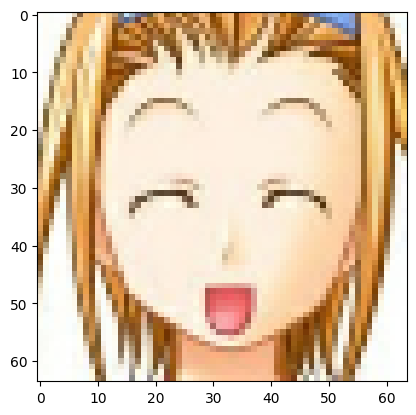

In [14]:
import matplotlib.pyplot as plt

for batch in pics_dataset.take(1):
    print(batch.shape)
    plt.imshow((batch[0] + 1) / 2.0)
    plt.show()


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_real_and_fake(generator, dataset, epoch, latent_dim=100):
    real_batch = next(iter(dataset))

    real_images = real_batch[:2]

    noise = tf.random.normal([2, latent_dim])
    fake_images = generator(noise, training=False)

    real_images = (real_images + 1) / 2.0
    fake_images = (fake_images + 1) / 2.0

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(2):
        axes[i].imshow(real_images[i].numpy())
        axes[i].set_title("Real")
        axes[i].axis("off")

    for i in range(2):
        axes[i+2].imshow(fake_images[i].numpy())
        axes[i+2].set_title("Fake")
        axes[i+2].axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.show()


Epoch 1 | Generator loss: 1.6640, Discriminator loss: 0.5840
Epoch 2 | Generator loss: 4.8771, Discriminator loss: 0.3385
Epoch 3 | Generator loss: 2.2425, Discriminator loss: 1.1037
Epoch 4 | Generator loss: 1.0368, Discriminator loss: 0.9677
Epoch 5 | Generator loss: 1.0040, Discriminator loss: 1.1677


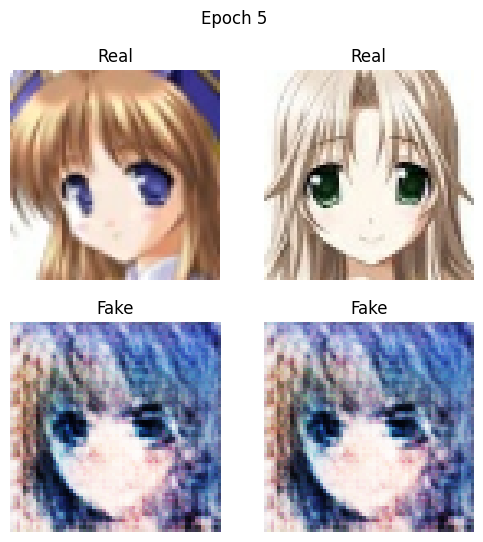

Epoch 6 | Generator loss: 3.6158, Discriminator loss: 0.0429
Epoch 7 | Generator loss: 2.1486, Discriminator loss: 0.2417
Epoch 8 | Generator loss: 1.7547, Discriminator loss: 0.8286
Epoch 9 | Generator loss: 5.8264, Discriminator loss: 0.1826
Epoch 10 | Generator loss: 3.0106, Discriminator loss: 1.5007


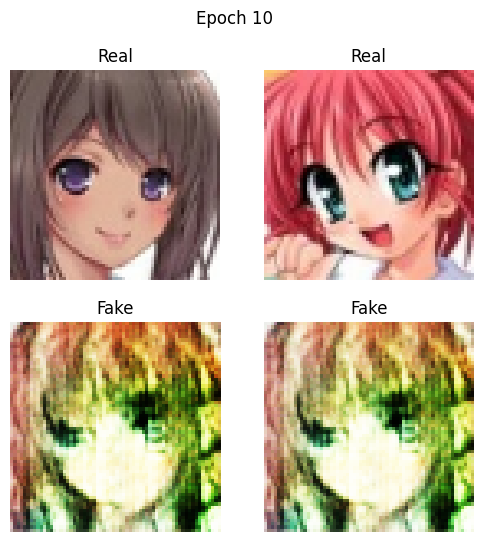

In [20]:
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    for real_batch in pics_dataset:
        g_loss, d_loss = train_step(real_batch)

    print(f"Epoch {epoch} | Generator loss: {g_loss:.4f}, Discriminator loss: {d_loss:.4f}")

    if (epoch % 5 == 0):
      show_real_and_fake(generator, pics_dataset, epoch, latent_dim=100)


Epoch 1 | Generator loss: 3.4346, Discriminator loss: 0.5691
Epoch 2 | Generator loss: 1.1952, Discriminator loss: 0.5575
Epoch 3 | Generator loss: 7.8475, Discriminator loss: 0.0911
Epoch 4 | Generator loss: 1.1167, Discriminator loss: 0.6674


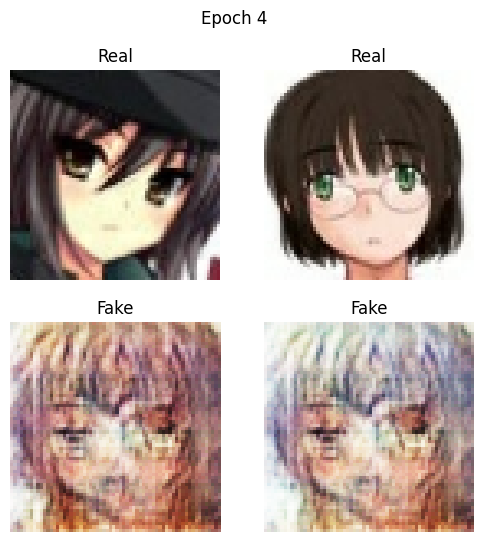

Epoch 5 | Generator loss: 5.9633, Discriminator loss: 0.3690
Epoch 6 | Generator loss: 1.3136, Discriminator loss: 0.5680
Epoch 7 | Generator loss: 6.2728, Discriminator loss: 0.0224
Epoch 8 | Generator loss: 2.3244, Discriminator loss: 0.2362


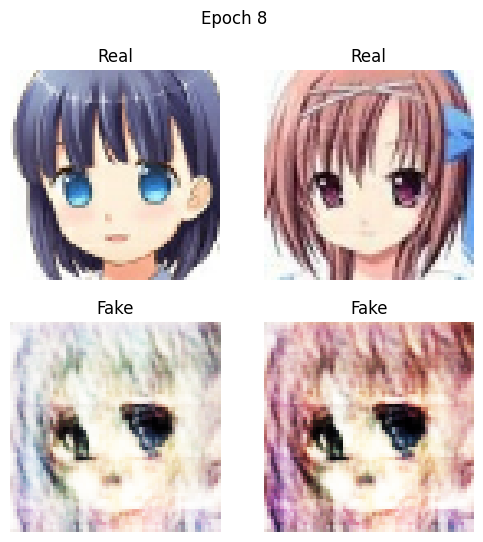

Epoch 9 | Generator loss: 2.5208, Discriminator loss: 0.3350
Epoch 10 | Generator loss: 8.1675, Discriminator loss: 0.4928
Epoch 11 | Generator loss: 1.9073, Discriminator loss: 0.7522
Epoch 12 | Generator loss: 4.0340, Discriminator loss: 0.2002


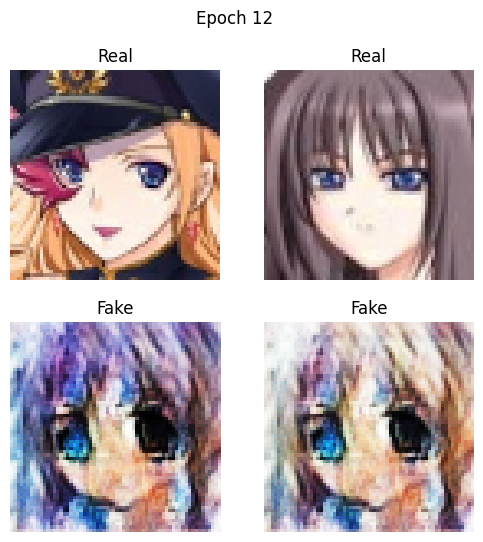

Epoch 13 | Generator loss: 1.9523, Discriminator loss: 0.2923
Epoch 14 | Generator loss: 5.9989, Discriminator loss: 0.1629
Epoch 15 | Generator loss: 5.6056, Discriminator loss: 0.0171
Epoch 16 | Generator loss: 1.8247, Discriminator loss: 0.6062


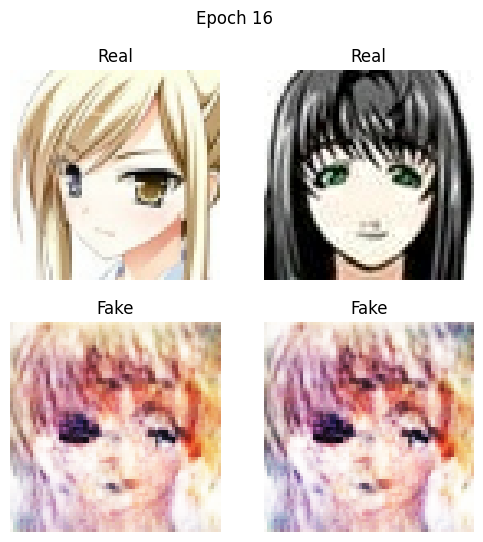

Epoch 17 | Generator loss: 4.5116, Discriminator loss: 0.0599
Epoch 18 | Generator loss: 0.2445, Discriminator loss: 2.4894
Epoch 19 | Generator loss: 3.1238, Discriminator loss: 0.2097
Epoch 20 | Generator loss: 2.9378, Discriminator loss: 0.3394


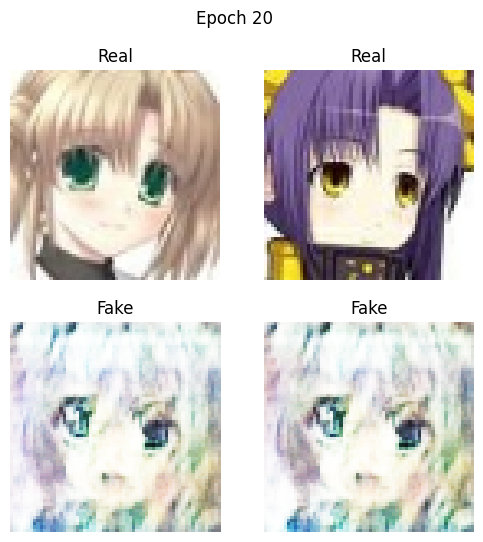

In [21]:
EPOCHS = 20

for epoch in range(1, EPOCHS+1):
    for real_batch in pics_dataset:
        g_loss, d_loss = train_step(real_batch)

    print(f"Epoch {epoch} | Generator loss: {g_loss:.4f}, Discriminator loss: {d_loss:.4f}")

    if (epoch % 4 == 0):
      show_real_and_fake(generator, pics_dataset, epoch, latent_dim=100)


In [29]:
def show_fake_images(generator, epoch, latent_dim=100, num_images=10):
    noise = tf.random.normal([num_images, latent_dim])
    fake_images = generator(noise, training=False)
    fake_images = (fake_images + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]

    rows = num_images // 2
    fig, axes = plt.subplots(rows, 2, figsize=(6, 3 * rows))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(fake_images[i].numpy())
        axes[i].set_title(f"Fake {i+1}")
        axes[i].axis("off")

    plt.suptitle(f"Epoch {epoch} — Generator Output")
    plt.tight_layout()
    plt.show()


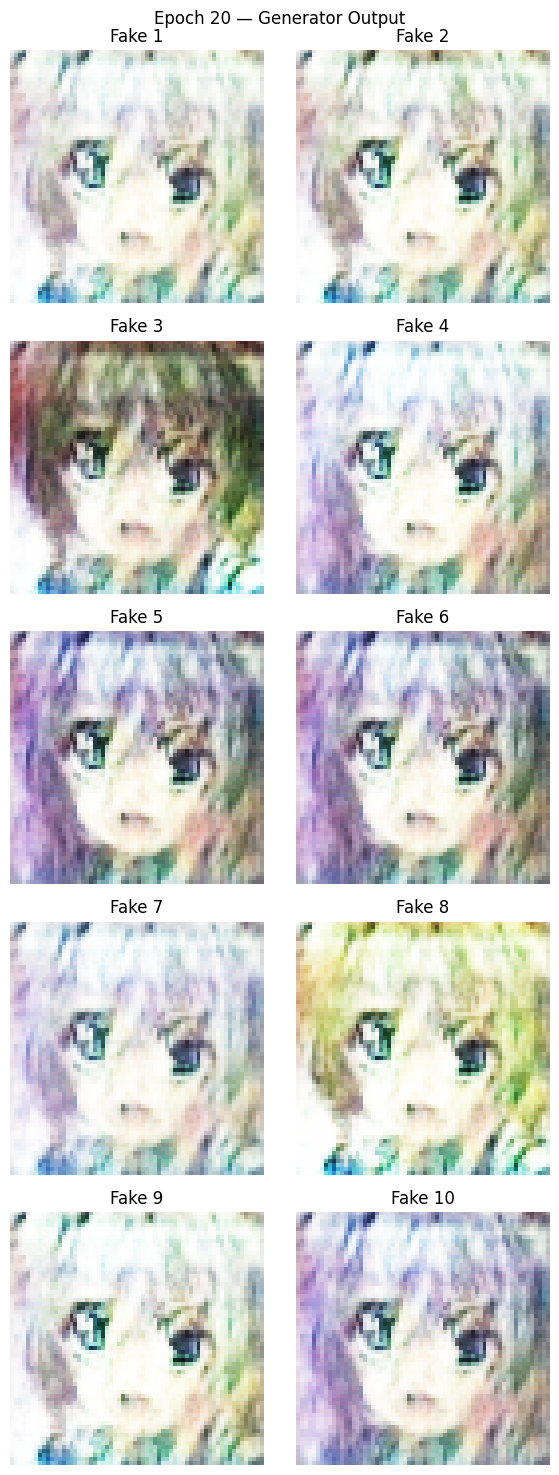

In [30]:
show_fake_images(generator, epoch, latent_dim=100)

In [32]:
generator.save_weights("generator_anime_face.weights.h5")
discriminator.save_weights("discriminator_anime_face.weights.h5")



In [35]:
%cd ..


/content


In [36]:
import shutil
shutil.move("generator_anime_face.weights.h5", "/content/GAN_image_generation/generator_anime_face.weights.h5")
shutil.move("discriminator_anime_face.weights.h5", "/content/GAN_image_generation/discriminator_anime_face.weights.h5")


'/content/GAN_image_generation/discriminator_anime_face.weights.h5'

In [37]:
%cd GAN_image_generation

/content/GAN_image_generation


In [38]:
!git add --all

In [43]:
!git config --global user.email "kiarashk111@gmail.com"
!git config --global user.name "kiarashkh"
!git commit -m "made anime face generator and saved weights"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [1]:
!git push

fatal: not a git repository (or any of the parent directories): .git
